<a href="https://colab.research.google.com/github/SYBIOTE/CMEPCMGN/blob/main/comouflage_gen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#repositories

In [2]:
!git clone https://github.com/experiencor/deep-viz-keras
!git clone https://github.com/SYBIOTE/camogen
!git clone https://github.com/matterport/Mask_RCNN

Cloning into 'deep-viz-keras'...
remote: Enumerating objects: 46, done.
remote: Total 46 (delta 0), reused 0 (delta 0), pack-reused 46
Unpacking objects: 100% (46/46), done.
Cloning into 'camogen'...
remote: Enumerating objects: 89, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 89 (delta 2), reused 0 (delta 0), pack-reused 79
Unpacking objects: 100% (89/89), done.
Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.23 MiB | 31.77 MiB/s, done.
Resolving deltas: 100% (562/562), done.


# image path 



In [12]:
IMAGE_PATH = "/content/Mask_RCNN/images/3627527276_6fe8cd9bfe_z.jpg"

# RCNN

In [13]:
pip install Mask_RCNN/

Processing ./Mask_RCNN
  Created wheel for mask-rcnn: filename=mask_rcnn-2.1-cp37-none-any.whl size=56924 sha256=ce1b0fc9f3c5b4e2fb231ca94094be4e98307280fed4e6957a42e4da7d007aa2
  Stored in directory: /tmp/pip-ephem-wheel-cache-1svf3nhz/wheels/78/da/b4/63931b0b9847ef98ac88d2b032817246adcf667c5da577133f
Successfully built mask-rcnn
  Found existing installation: mask-rcnn 2.1
    Uninstalling mask-rcnn-2.1:
      Successfully uninstalled mask-rcnn-2.1


In [14]:
%tensorflow_version 1.x

In [15]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("/content/Mask_RCNN/")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

In [16]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [17]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

In [18]:
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']


In [19]:
image = skimage.io.imread(IMAGE_PATH)

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]

Processing 1 images
image                    shape: (476, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  119.30000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32



# mask and filtering

Text(0.5, 1.0, 'original')

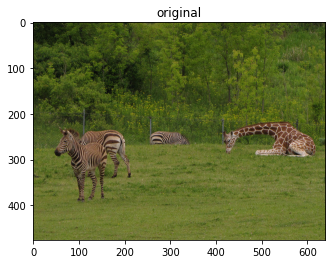

In [20]:
plt.imshow(image)
plt.title("original")

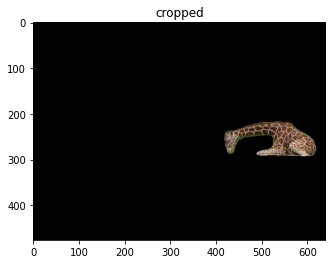

In [21]:
i = 0
mask = r["masks"]
cropped = image.copy()
for j in range(cropped.shape[2]):

    cropped[:,:,j] = cropped[:,:,j] * mask[:,:,i]


plt.imshow(cropped)
plt.title("cropped")
i+=1

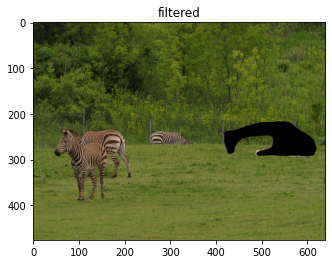

In [22]:
i = 0
mask = r["masks"]
filtered = image.copy()
for j in range(filtered.shape[2]):

    filtered[:,:,j] = filtered[:,:,j] - cropped[:,:,j]


plt.imshow(filtered)
plt.title("filtered")
i+=1

# Color Extraction

## load image

In [23]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import SpectralClustering

In [24]:
dominant_color = 5
hexadecimal_color_minibatch_kmean = []
hexadecimal_color_kmean = []
score_minibatch = []
score = []

(476, 640, 3)


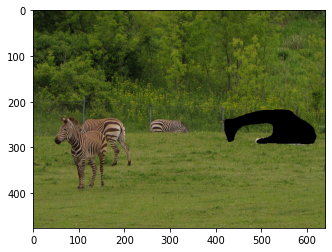

In [25]:
img = filtered

x_end , y_end = img.shape[0:2]
print(img.shape)

plt.imshow(img ,extent=[0,y_end,x_end,0])

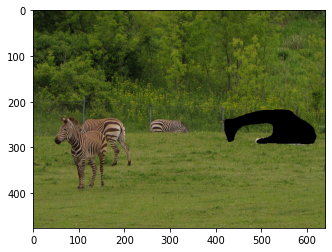

In [26]:
# img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img , extent=[0,y_end,x_end,0])

In [27]:
original_pixel = img.shape
print(original_pixel)

(476, 640, 3)


In [28]:
pixel = img.reshape((x_end*y_end , 3))
print(pixel.shape)

(304640, 3)


## K-means minibatch

In [29]:
%%time
km = MiniBatchKMeans( n_clusters = dominant_color)
km.fit(pixel)

CPU times: user 1.33 s, sys: 38 ms, total: 1.37 s
Wall time: 1.35 s


[[ 41  53  15]
 [100 112  42]
 [123 128  65]
 [  6   6   2]
 [ 70  85  25]]
['#29350f', '#64702a', '#7b8041', '#060602', '#465519']


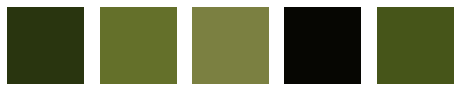

In [30]:
minibatch_centers = km.cluster_centers_
# A uint8 data type contains all whole numbers from 0 to 255.
minibatch_centers = np.array(minibatch_centers , dtype='uint8')
# avg = [0,0,0]
# for x in minibatch_centers:
#     if not (x[0]==x[1]==x[2]==0):
#       avg += (x/len(minibatch_centers)-1)
# print(avg)
# minibatch_centers[np.where(minibatch_centers == [0,0,0])] = avg

print(minibatch_centers)
hexadecimal_color_minibatch_kmean.clear()
for array in minibatch_centers:
  hexadecimal_color_minibatch_kmean.append( '#%02x%02x%02x' % (array[0], array[1], array[2]) )

print(hexadecimal_color_minibatch_kmean)
#Plotting these colors

i =1
plt.figure(0,figsize=(8,2))


color = []
for x in minibatch_centers:
    plt.subplot(1,5,i)
    plt.axis("off")
    i+=1
    color.append(x)
    a = np.zeros((100,100,3),dtype='uint8')
    a[:,:,:] = x
    plt.imshow(a)

plt.show()



In [31]:
%%time
score_minibatch.clear()
for i in range(dominant_color):
  sum=0
  for j in km.labels_:
    if(i == j):
      sum += 1
  score_minibatch.append(sum/len(km.labels_))

print(score_minibatch)
print(hexadecimal_color_minibatch_kmean)


[0.14082851890756304, 0.32219997373949577, 0.18841583508403362, 0.04883469012605042, 0.29972098214285714]
['#29350f', '#64702a', '#7b8041', '#060602', '#465519']
CPU times: user 2.79 s, sys: 8.55 ms, total: 2.8 s
Wall time: 2.83 s


### forward

In [32]:
centers = km.cluster_centers_
# A uint8 data type contains all whole numbers from 0 to 255.
centers = np.array(centers , dtype='uint8')
print("After : ",centers)

After :  [[ 41  53  15]
 [100 112  42]
 [123 128  65]
 [  6   6   2]
 [ 70  85  25]]


In [33]:
for array in centers:
  hexadecimal_color_kmean.append( '#%02x%02x%02x' % (array[0], array[1], array[2]) )


In [34]:
hexadecimal_color_kmean

['#29350f', '#64702a', '#7b8041', '#060602', '#465519']

In [35]:
hexadecimal_color

NameError: ignored

In [ ]:

#Plotting these colors

i =1
plt.figure(0,figsize=(8,2))


color = []
for x in centers:
    plt.subplot(1,5,i)
    plt.axis("off")
    i+=1
    color.append(x)
    
    a = np.zeros((100,100,3),dtype='uint8')
    a[:,:,:] = x
    plt.imshow(a)
plt.show()



In [ ]:
%%time
score = []
for i in range(dominant_color):
  sum=0
  for j in km.labels_:
    if(i == j):
      sum += 1
  score.append(sum/len(km.labels_))

print(score)
print(hexadecimal_color)

In [ ]:
# segmenting the original image
new_pixel = np.zeros((x_end*y_end , 3))

color 

In [ ]:
km.labels_

In [ ]:
for i in range(new_pixel.shape[0]):
  new_pixel[i] = color[km.labels_[i]]

new_pixel = new_pixel.reshape(original_pixel)

In [ ]:
plt.imshow(img ,extent=[0,y_end,x_end,0])
plt.title("Before segmentation")
plt.show()

In [ ]:
new_pixel /= 255

In [ ]:
plt.imshow(new_pixel , extent=[0,y_end,x_end,0])
plt.title("After Segmentation")
plt.show()

In [ ]:
new_pixel

In [ ]:
from PIL import Image
im = Image.fromarray(new_pixel)
im.save("segmented.jpg")


In [ ]:
import scipy.misc
scipy.misc.imsave('outfile.jpg', new_pixel)

#Camogen

In [36]:
pip install /content/camogen

Processing ./camogen
  Created wheel for Camogen: filename=Camogen-0.1-cp37-none-any.whl size=9733 sha256=456948dd897f1a7abdbc99897805655a8938a3cefb156c89bfbec16681581734
  Stored in directory: /tmp/pip-ephem-wheel-cache-nod_xm5_/wheels/27/b0/23/041bdf4776dc0ce4676d1d09369e681caf2b0c9519e3d4e40e
Successfully built Camogen


In [37]:
yp = hexadecimal_color_minibatch_kmean
hexadecimal_color_minibatch_kmean = []
for i in yp:
   if i == '#dbe1d9':
     pass
   else:
     hexadecimal_color_minibatch_kmean.append(i)

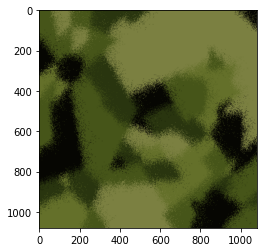

In [38]:
import camogen
import matplotlib.pyplot as plt
from camogen.generate import generate


parameters = {'width': 1080, 'height': 1080, 'polygon_size': 500, 'color_bleed': 1,'max_depth':8,
              'colors': hexadecimal_color_minibatch_kmean,
              'spots': {'amount': 200000, 'radius': {'min': 1, 'max': 10}, 'sampling_variation': 5},
              'pixelize': {'percentage': 1, 'sampling_variation': 20, 'density': {'x': 400, 'y': 400}}}
camo_pattern = generate(parameters)
plt.imshow(camo_pattern)
# camo_pattern.save('/content/camogen/images/genrated.png')

#pattern overlappping

In [ ]:
# a = np.array(filtered)
# b = np.array(camo_pattern)
# for c in range(a.shape[2]):
#   for j in range(a.shape[1]):
#     for r in range(a.shape[0]):
#       if r == 0:
#         a[r,j,c] = camo_pattern[r,j,c]



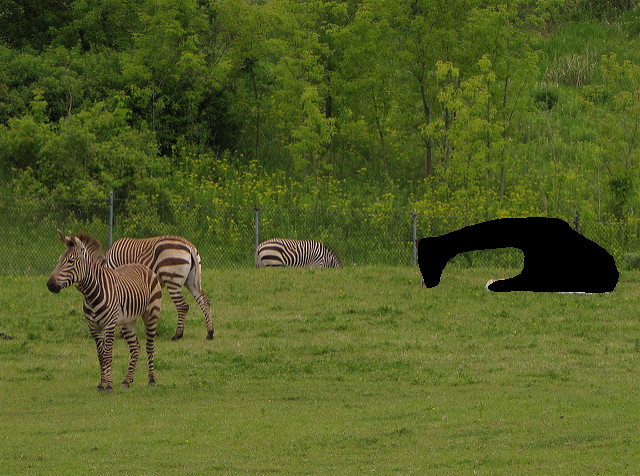

In [39]:
import PIL
from PIL import Image
import requests
from io import BytesIO
from PIL import ImageFilter
from PIL import ImageEnhance
from IPython.display import display
import numpy as np


pil_filtered = Image.fromarray(filtered)
pil_camo = Image.fromarray(np.array(camo_pattern))

pil_filtered

In [40]:
 pil_filtered.size , pil_camo.size

((640, 476), (1080, 1080))

In [41]:
width, height = pil_filtered.size
camo_w, camo_h = pil_camo.size
camo_w, camo_h = camo_w//2, camo_h//2
for j in range(height):
  for r in range(width):
    rgb_values = pil_filtered.getpixel((r,j))
    if 0 in rgb_values:
      l = r
      k = j
      if l > camo_h or k > camo_w:
        l = random.randint(0,camo_w)
        k = random.randint(0,camo_h)
      pil_filtered.putpixel( (r,j), pil_camo.getpixel((l,k))  )
     


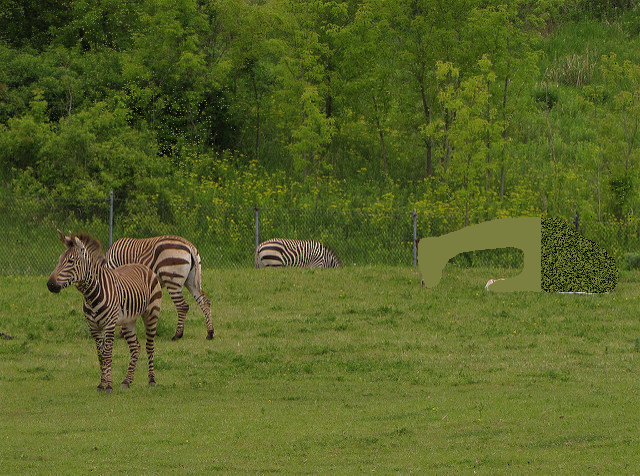

In [42]:
pil_filtered

# Effectiveness check

## detection test

In [43]:
pix = np.array(pil_filtered)

In [44]:
test = model.detect([pix], verbose=1)

Processing 1 images
image                    shape: (476, 640, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  119.20000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


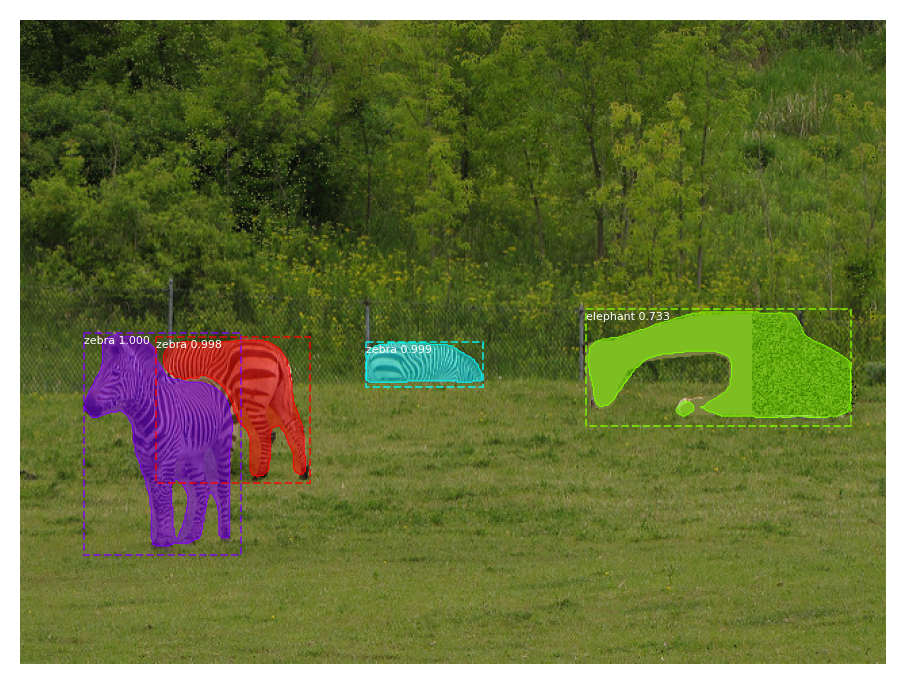

In [45]:
# Visualize results
t = test[0]
visualize.display_instances(pix, t['rois'], t['masks'], t['class_ids'], 
                            class_names, t['scores'])

## saliency map



In [ ]:
cd deep-viz-keras/

/content/deep-viz-keras


In [ ]:
import PIL as PIL
from PIL import Image
from PIL import *
import numpy as np
from matplotlib import pylab as plt
def show_image(image, grayscale = True, ax=None, title=''):
    if ax is None:
        plt.figure()
    plt.axis('off')
    
    if len(image.shape) == 2 or grayscale == True:
        if len(image.shape) == 3:
            image = np.sum(np.abs(image), axis=2)
            
        vmax = np.percentile(image, 99)
        vmin = np.min(image)

        plt.imshow(image, cmap=plt.cm.gray, vmin=vmin, vmax=vmax)
        plt.title(title)
    else:
        image = image + 127.5
        image = image.astype('uint8')
        
        plt.imshow(image)
        plt.title(title)
    
def load_image(file_path):
    im = PIL.Image.open(file_path)
    im = np.asarray(im)
    
    return im - 127.5

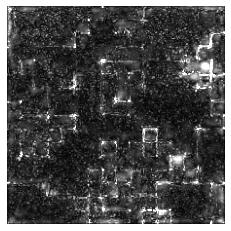

In [ ]:
from saliency import GradientSaliency
#from utils import *
from keras.applications.vgg16 import VGG16
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution() 
# Load the pretrained VGG16 model and make the guided backprop operator
model = VGG16(weights='imagenet')
model.compile(loss='categorical_crossentropy', optimizer='adam')

vanilla = GradientSaliency(model)
 
# Load the image and compute the guided gradient
image = load_image('/content/camogen/images/genrated.png')
mask = vanilla.get_smoothed_mask(image)            # compute the gradients
show_image(mask)                                  # display the grayscaled mask